In [102]:
import torch
from torch import nn
import torchvision
import torchvision.transforms.v2
from torchvision.transforms.v2 import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [22]:
train_data = datasets.MNIST(root = 'data',
                            train = True,
                            transform = ToTensor(),
                            download = True,
                            target_transform=None)

test_data = datasets.MNIST(root = 'data',
                           train = False,
                           transform = ToTensor(),
                           download = True,
                           target_transform=None)

In [23]:
len(train_data), len(test_data)

(60000, 10000)

In [24]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [25]:
image, label = train_data[0]

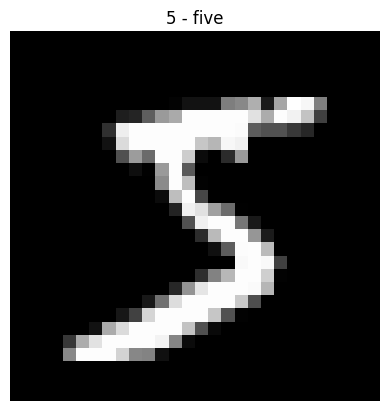

In [26]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False);

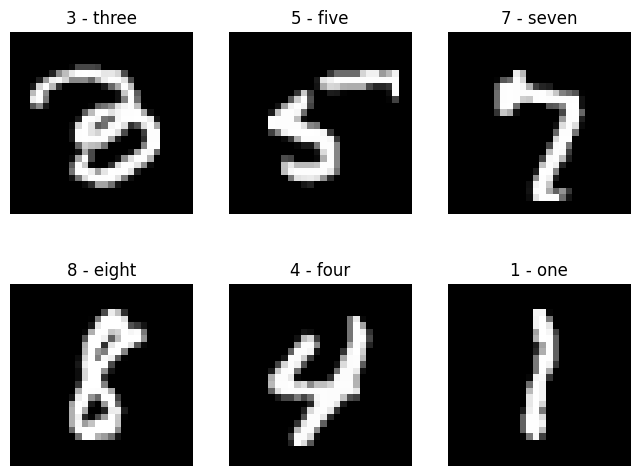

In [27]:
#torch.manual_seed(42)
fig = plt.figure(figsize=(8,6))
nrows = 2
ncols = 3
for i in range(1, nrows*ncols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(nrows, ncols, i)
  plt.imshow(image.squeeze(), cmap = 'gray')
  plt.title(class_names[label])
  plt.axis(False)

In [28]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [29]:
batch_train_features, batch_train_labels = next(iter(train_dataloader))

In [30]:
print(f'We have {len(train_dataloader)} batches of images of size {batch_size}')
print(f'We have {len(test_dataloader)} batches of images of size {batch_size}')

We have 1875 batches of images of size 32
We have 313 batches of images of size 32


In [31]:
batch_train_features[0].shape, batch_train_labels[0].shape

(torch.Size([1, 28, 28]), torch.Size([]))

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [33]:
class TinyVGGModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size= 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size= 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.layer_stack_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size= 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size= 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.output_classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7, out_features = output_shape)
    )

  def forward(self, x):
    x = self.layer_stack_1(x)
    #print(x.shape)
    x = self.layer_stack_2(x)
    #print(x.shape)
    x = self.output_classifier_layer(x)
    #print(x.shape)
    return x

In [34]:
model_0 = TinyVGGModel(1,10,10).to(device)
model_0

TinyVGGModel(
  (layer_stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [35]:
from sklearn.metrics import accuracy_score
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr = 0.1, params = model_0.parameters())

In [36]:
next(model_0.parameters()).device

device(type='cpu')

In [37]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

start_time_cpu_model = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n-----------------')
  train_loss = 0
  train_acc = 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_score(y, y_pred.argmax(dim = 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss = 0
  test_acc = 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_score(y_test, test_pred.argmax(dim = 1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc*100:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc*100:.3f}')

end_time_cpu_model = timer()
model_time_cpu = end_time_cpu_model - start_time_cpu_model
print(f'Time of training and testing the model = {model_time_cpu}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----------------
Train Loss: 0.32994 | Train Accuracy: 88.868 | Test Loss: 0.07898 | Test Accuracy: 97.414
Epoch: 1
-----------------
Train Loss: 0.08127 | Train Accuracy: 97.492 | Test Loss: 0.06580 | Test Accuracy: 97.913
Epoch: 2
-----------------
Train Loss: 0.06248 | Train Accuracy: 98.070 | Test Loss: 0.06185 | Test Accuracy: 97.973
Epoch: 3
-----------------
Train Loss: 0.05232 | Train Accuracy: 98.440 | Test Loss: 0.04572 | Test Accuracy: 98.433
Epoch: 4
-----------------
Train Loss: 0.04630 | Train Accuracy: 98.535 | Test Loss: 0.05050 | Test Accuracy: 98.363
Time of training and testing the model = 323.7260663259999


In [26]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

model_0_gpu = TinyVGGModel(1, 10, 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr = 0.1, params = model_0_gpu.parameters())

print(f'Model running on {device}')

start_time_gpu_model = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n-----------------')
  train_loss = 0
  train_acc = 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model_0_gpu(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss = 0
  test_acc = 0
  model_0_gpu.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model_0_gpu(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim = 1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.3f} %')

end_time_gpu_model = timer()
model_time_gpu = end_time_gpu_model - start_time_gpu_model
print(f'Time of training and testing the model on {device} = {model_time_gpu:.3f} seconds')

Model running on cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----------------


KeyboardInterrupt: 

In [74]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 12):
  test_samples.append(sample)
  test_labels.append(label)

In [75]:
test_samples[0].shape, class_names[test_labels[0]]

(torch.Size([1, 28, 28]), '0 - zero')

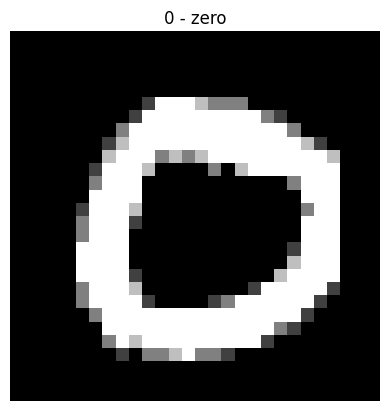

In [76]:
plt.imshow(test_samples[0].squeeze(0), cmap='gray')
plt.title(class_names[test_labels[0]])
plt.axis(False);

In [77]:
preds = []
model_0.eval()
with torch.inference_mode():
  for sample in test_samples:
    sample = torch.unsqueeze(sample, dim = 0).to(device)
    logit = model_0(sample)
    pred = torch.softmax(logit.squeeze(), dim = 0)
    preds.append(pred.cpu())
preds = torch.stack(preds)
preds = preds.argmax(dim = 1)
preds

tensor([0, 8, 7, 5, 1, 6, 8, 2, 7, 4, 1, 3])

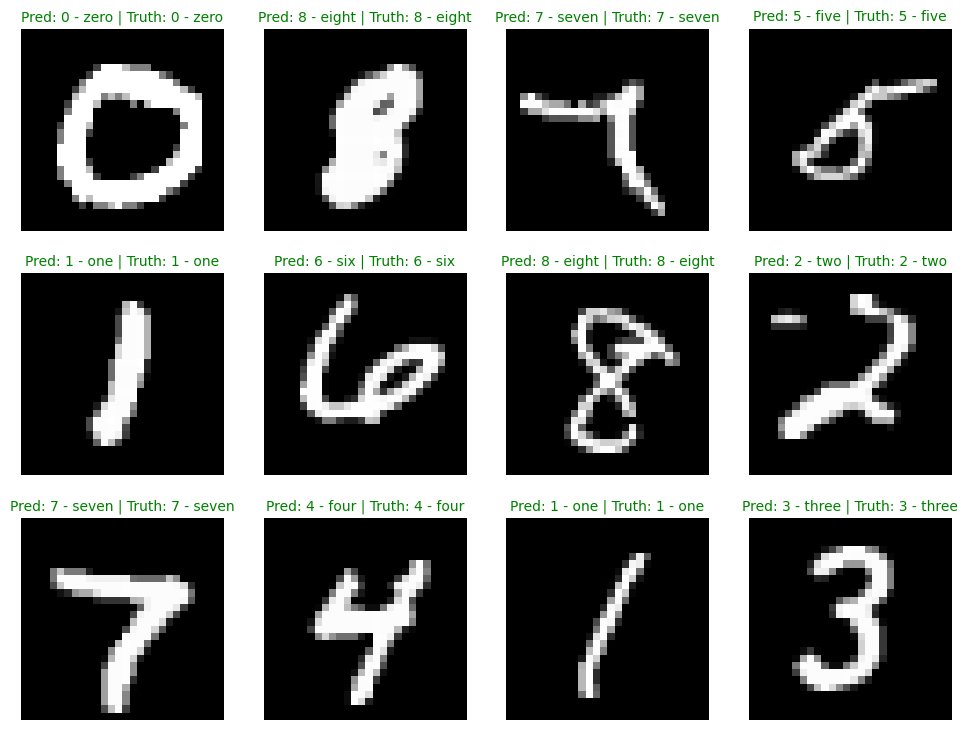

In [78]:
nrows = 3
ncols = 4
plt.figure(figsize=(12,9))

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')
  pred_label = class_names[preds[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c='g')
  else:
    plt.title(title_text, fontsize = 10, c='r')

  plt.axis(False)

In [116]:
from tqdm.auto import tqdm
all_preds = []
model_0.eval()
model_0.to(device)
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    logits = model_0(X)
    predictions = torch.softmax(logits, dim = 0).argmax(dim = 1)
    all_preds.append(predictions)
all_preds_tensor = torch.cat(all_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

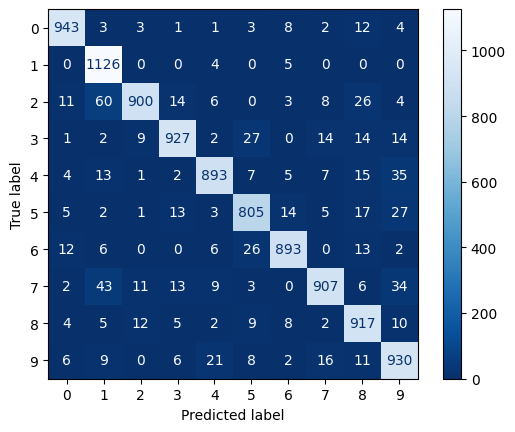

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_pred = all_preds_tensor, y_true = test_data.targets, cmap='Blues_r')

In [122]:
random_tensor = torch.rand(size=[1,3,64,64])

In [141]:
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [134]:
conv2d_layer = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, stride = 1, padding = 0)

In [75]:
conv_random_tensor = conv2d_layer(random_tensor)
conv_random_tensor.shape

NameError: name 'conv2d_layer' is not defined

In [103]:
train_data_fashion = datasets.FashionMNIST(root = 'data',
                                           download = True,
                                           train = True,
                                           transform = ToTensor(),
                                           target_transform = None)

test_data_fashion = datasets.FashionMNIST(root = 'data',
                                           download = True,
                                           train = False,
                                           transform = ToTensor(),
                                           target_transform = None)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [104]:
len(train_data_fashion), len(test_data_fashion)

(60000, 10000)

In [105]:
image, label = train_data_fashion[0]

In [106]:
image.shape

torch.Size([1, 28, 28])

In [107]:
fashion_class_names = train_data_fashion.classes
fashion_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

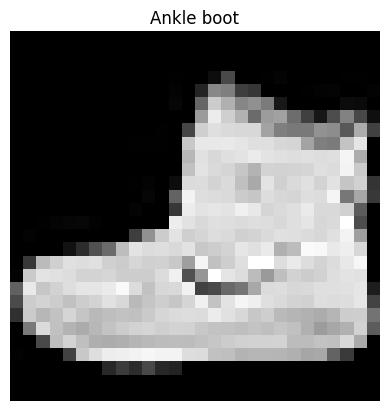

In [108]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(fashion_class_names[label])
plt.axis(False);

In [109]:
BATCH_SIZE = 32
fashion_train_dataloader = DataLoader(train_data_fashion, batch_size = BATCH_SIZE, shuffle = True)
fashion_test_dataloader = DataLoader(test_data_fashion, batch_size = BATCH_SIZE, shuffle = False)

In [110]:
print(f'{len(fashion_train_dataloader)} batches of size {BATCH_SIZE} resulting in the whole train dataset of size {len(fashion_train_dataloader) * BATCH_SIZE}')
print(f'{len(fashion_test_dataloader)} batches of size {BATCH_SIZE} resulting in the whole test dataset of size {len(fashion_test_dataloader) * BATCH_SIZE}')

1875 batches of size 32 resulting in the whole train dataset of size 60000
313 batches of size 32 resulting in the whole test dataset of size 10016


In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [112]:
class FashionMNIST_TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, padding = 0, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 0, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 0, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 0, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.output_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*4*4, out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.output_layer(x)
    return x

In [113]:
fashion_model_0 = FashionMNIST_TinyVGG(1, 10, 10).to(device)
fashion_model_0

FashionMNIST_TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [114]:
next(fashion_model_0.parameters()).device

device(type='cpu')

In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr = 0.1, params = fashion_model_0.parameters())

In [116]:
sample_image, sample_label = next(iter(fashion_test_dataloader))

In [117]:
sample_image[0].shape

torch.Size([1, 28, 28])

In [118]:
dummy_prediciton = fashion_model_0(sample_image[0].unsqueeze(0).to(device))

In [119]:
torch.softmax(dummy_prediciton, dim = 1)

tensor([[0.0937, 0.1034, 0.0931, 0.1020, 0.1115, 0.0968, 0.1075, 0.0955, 0.0990,
         0.0973]], grad_fn=<SoftmaxBackward0>)

In [120]:
torch.softmax(dummy_prediciton, dim = 1).argmax(dim = 1)

tensor([4])

(-0.5, 27.5, 27.5, -0.5)

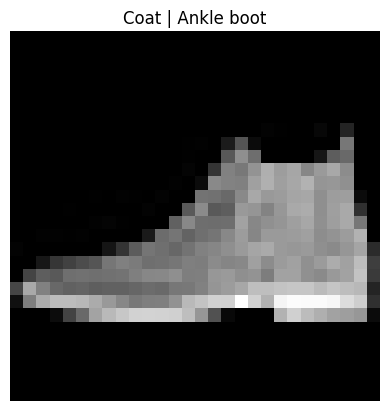

In [121]:
plt.imshow(sample_image[0].squeeze(), cmap='gray')
plt.title(f'{fashion_class_names[torch.softmax(dummy_prediciton, dim = 1).argmax(dim = 1)]} | {fashion_class_names[sample_label[0]]}')
plt.axis(False)

In [122]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fashion_model_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):

  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0, 0

  for batch, (X, y) in enumerate(fashion_train_dataloader):

    X, y = X.to(device), y.to(device).long()

    fashion_model_0.train()

    y_preds = fashion_model_0(X)

    loss = loss_fn(y_preds, y)
    train_loss += loss

    train_acc += accuracy_fn(y, y_preds.argmax(dim = 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(fashion_train_dataloader)
  train_acc /= len(fashion_train_dataloader)

  fashion_model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in fashion_test_dataloader:

      X_test, y_test = X_test.to(device), y_test.to(device)

      test_preds = fashion_model_0(X_test)

      test_loss += loss_fn(test_preds, y_test)

      test_acc += accuracy_fn(y_test, test_preds.argmax(dim = 1))

    test_loss /= len(fashion_test_dataloader)
    test_acc /= len(fashion_test_dataloader)

  print(
      f'Epoch {epoch}: Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.3f} %')

fashion_model_end = timer()
print(f'Total training and testing time = {fashion_model_end - fashion_model_start} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Train Loss: 0.73876 | Train Accuracy: 72.655 | Test Loss: 0.47994 | Test Accuracy: 82.588
Epoch 1: Train Loss: 0.43334 | Train Accuracy: 84.390 | Test Loss: 0.41269 | Test Accuracy: 85.174
Epoch 2: Train Loss: 0.38193 | Train Accuracy: 86.185 | Test Loss: 0.37529 | Test Accuracy: 86.691
Epoch 3: Train Loss: 0.35733 | Train Accuracy: 86.987 | Test Loss: 0.36617 | Test Accuracy: 86.621
Epoch 4: Train Loss: 0.34097 | Train Accuracy: 87.683 | Test Loss: 0.37402 | Test Accuracy: 86.322
Total training and testing time = 244.52500273099986 seconds


In [123]:
all_preds = []
fashion_model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(fashion_test_dataloader):
    X, y = X.to(device), y.to(device)
    y_preds = fashion_model_0(X)
    y_preds = torch.softmax(y_preds, dim = 1).argmax(dim = 1)
    all_preds.append(y_preds)
preds_tensor = torch.cat(all_preds).cpu()

  0%|          | 0/313 [00:00<?, ?it/s]

In [124]:
preds_tensor[:10], len(preds_tensor)

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [125]:
wrong_pred_indexes = np.where(preds_tensor != test_data_fashion.targets)[0]

In [126]:
len(wrong_pred_indexes)

1370

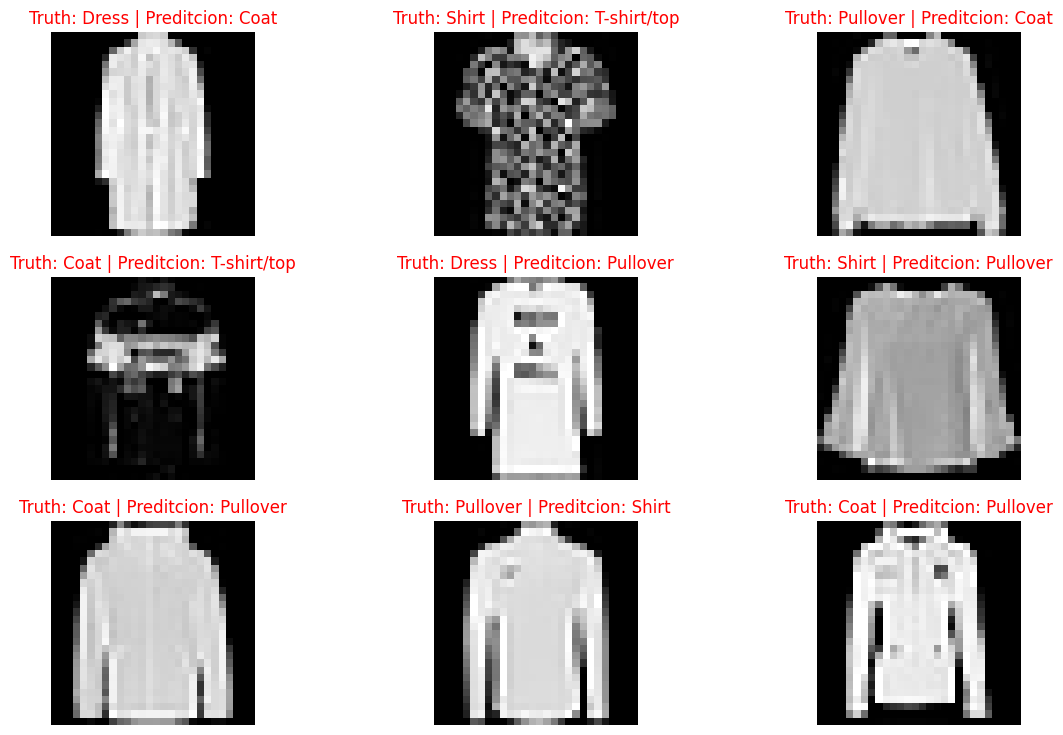

In [127]:
import random

rand_selection = random.sample(list(wrong_pred_indexes), k = 9)

plt.figure(figsize = (14,9))

for i, idx in enumerate(rand_selection):

  true_labels = fashion_class_names[test_data_fashion[idx][1]]
  pred_labels = fashion_class_names[preds_tensor[idx]]

  plt.subplot(3,3,i+1)
  plt.axis(False)
  plt.imshow(test_data_fashion[idx][0].squeeze(), cmap='gray')

  title = f'{true_labels} | {pred_labels}'
  if true_labels == pred_labels:
    plt.title(f'Truth: {true_labels} | Preditcion: {pred_labels}', c='g')
  else:
    plt.title(f'Truth: {true_labels} | Preditcion: {pred_labels}', c='r')